Remember the code we used with Sklearn to do K Nearest Neighbors? Here it is:

In [ ]:
import numpy as np
from sklearn import preprocessing, cross_validation, neighbors
import pandas as pd

df = pd.read_csv('breast-cancer-wisconsin.data.txt')
df.replace('?',-99999, inplace=True)
df.drop(['id'], 1, inplace=True)

X = np.array(df.drop(['class'], 1))
y = np.array(df['class'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

clf = neighbors.KNeighborsClassifier()


clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

example_measures = np.array([[4,2,1,1,1,2,3,2,1]])
example_measures = example_measures.reshape(len(example_measures), -1)
prediction = clf.predict(example_measures)
print(prediction)

We need to make only two simple changes here. The first is to import svm from sklearn, and the second is just to use the Support Vector Classifier, which is just svm.SVC. With our changes now:

In [ ]:
import numpy as np
from sklearn import preprocessing, cross_validation, neighbors, svm
import pandas as pd

df = pd.read_csv('breast-cancer-wisconsin.data.txt')
df.replace('?',-99999, inplace=True)
df.drop(['id'], 1, inplace=True)

X = np.array(df.drop(['class'], 1))
y = np.array(df['class'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

clf = svm.SVC()

clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

example_measures = np.array([[4,2,1,1,1,2,3,2,1]])
example_measures = example_measures.reshape(len(example_measures), -1)
prediction = clf.predict(example_measures)
print(prediction)

For me, my output was:


0.978571428571

[2]
Depending on your random sample, you should get something between 94 and 99%, averaging around 97% again. Also, timing the operation, recall that I got 0.044 seconds to execute the KNN code via Scikit-Learn. With the svm.SVC, execution time was a mere 0.00951, which is 4.6x faster on even this very small dataset.


So we can agree that the Support Vector Machine appears to get the same accuracy in this case, only at a much faster pace. Note that if we comment out the drop id column part, accuracy goes back down into the 60s. The Support Vector Machine, in general, handles pointless data better than the K Nearest Neighbors algorithm, and definitely will handle outliers better, but, in this example, the meaningless data is still very misleading for us. We are using the default parameters, however. Looking at the Documentation for the Support Vector Classification, there sure are quite a few parameters here that we have no idea what they're doing. In the coming tutorials, we're going to hop in the deep end to pull apart the Support Vector Machine algorithm so we can actually understand what all these parameters mean and how they affect things. While we're breaking things down, start thinking about: How to handle non-linearly seperable data and datasets with more than two classes (since and SVM is a binary classifier, in the sense that it draws a line to divide two groups).

Beginning SVM from Scratch in Python

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
style.use('ggplot')

We'll be using matplotlib to plot and numpy for handling arrays. Next we'll have some starting data:

In [2]:
data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8],]),

             1:np.array([[5,1],
                         [6,-1],
                         [7,3],])}

Now we are going to begin building our Support Vector Machine class. If you are not familiar with object oriented programming, don't fret. Our example here will be a very rudimentary form of OOP. Just know that OOP creates objects with attributes, the functions within the class are actually methods, and we use "self" on variables that can be referenced anywhere within the class (or object). This is by no means a great explanation, but it should be enough to get you going. If you are confused about the code, just ask!

In [3]:
class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)

The __init__ method of a class is one that runs whenever an object is created with the class. The other methods will only run when called to run. For every method, we pass "self" as the first parameter mainly out of standards. Next, we are adding a visualization parameter. We're going to want to see the SVM most likely, so we're setting that default to true. Next, you can see some variables like self.color and self.visualization. Doing this will allow us to reference self.colors for example in other methods within our class. Finally, if we have visualization turned on, we're going to begin setting up our graph.

Next, let's go ahead and add a couple more methods: fit and predict.

In [4]:
class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        pass

    def predict(self,features):
        # sign( x.w+b )
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)

        return classification

The fit method will be used to train our SVM. This will be the optimization step. The predict method will predict the value of a new featureset once we've trained the classifier, which is just the sign(x.w+b) once we know what w and b are.

The full code up to this point:

In [5]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
style.use('ggplot')

class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        pass

    def predict(self,features):
        # sign( x.w+b )
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)

        return classification

data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8],]),

             1:np.array([[5,1],
                         [6,-1],
                         [7,3],])}

We'll begin adding to the fit method:

In [6]:
def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}

        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]

Note that this method is first passing self (remember, just standard to do this with a method), then data is passed. The data is the data we intend to train against / optimize with. In our case, that's going to be data_dict, which we've already created

We set self.data to that data. Now, we can reference the training data anywhere else in the class (but again, we'd have to run the train method first with data for it to work without an error).

Next, we begin building an optimization dictionary as opt_dict, which is going to contain any optimization values. As we step down our w vector, we'll test that vector in our constraint function, finding the largest b, if any, that will satisfy the equation, and then we'll store all of that data in our optimization dictionary. The dictionary will be { ||w|| : [w,b] }. When we're all done optimizing, we'll choose the values of w and b for whichever one in the dictionary has the lowest key value (which is ||w||).

Finally, we set our transforms. We've explained that our intention there is to make sure we check every version of the vector possible.

Next, we need some starting point that matches our data. To do this, we're going to first reference our training data to pick some haflway decent starting values:

In [10]:
# finding values to work with for our ranges.
all_data = []
for yi in self.data:
      for featureset in self.data[yi]:
          for feature in featureset:
            all_data.append(feature)

self.max_feature_value = max(all_data)
self.min_feature_value = min(all_data)
# no need to keep this memory.
all_data=None

NameError: name 'self' is not defined

All we're doing here is cycling through all of our data, and finding the highest and lowest values. Now we're going to work on our step sizes:

In [11]:
step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # starts getting very high cost after this.
                      self.max_feature_value * 0.001]

NameError: name 'self' is not defined

What we're doing here is setting some sizes per step that we want to make. For our first pass, we'll take big steps (10%). Once we find the minimum with these steps, we're going to step down to a 1% step size to continue finding the minimum here. Then, one more time, we step down to 0.1% for fine tuning. We could continue stepping down, depending on how precise you want to get. I will discuss towards the end of this project how you could determine within your program whether or not you should continue optimizing or not.

Next, we're going to set some variables that will help us make steps with b (used to make larger steps than we use for w, since we care far more about w precision than b), and keep track of the latest optimal value:

In [13]:
# extremely expensive
b_range_multiple = 5
b_multiple = 5
latest_optimum = self.max_feature_value*10

NameError: name 'self' is not defined

Now we're ready to begin stepping

In [14]:
for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                pass

NameError: name 'step_sizes' is not defined

The idea here is to begin stepping down the vector. To begin, we'll set optimized to False, and we'll reset this for each major step. The optimized var will be true when we have checked all steps down to the base of the convex shape (our bowl).

We will pick up with the logic in the next tutorial, where we actually plug in values to the constraint problem to see if we can find values to save.

Full code up to this point:

In [15]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
style.use('ggplot')

class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}

        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]

        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None

        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # point of expense:
                      self.max_feature_value * 0.001,]

        # extremely expensive
        b_range_multiple = 5
        #
        b_multiple = 5
        latest_optimum = self.max_feature_value*10

        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                pass

    def predict(self,features):
        # sign( x.w+b )
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)

        return classification



data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8],]),

             1:np.array([[5,1],
                         [6,-1],
                         [7,3],])}

Picking up with the while not optimized part:

In [17]:
optimized = False
while not optimized:
  for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                       self.max_feature_value*b_range_multiple,
                           step*b_multiple):

SyntaxError: incomplete input (<ipython-input-17-fea9f8971e12>, line 5)

Here, we begin also iterating through possible b values, and now you can see our b values we set earlier in action. I will note here that we're straight iterating through b with a constant step-size. We could also break down b steps just like we did with w. To make things more accurate and precise, you probably would want to implement that. That said, I am going to skip doing that for brevity, since we'll achieve similar results either way and we're not trying to win any awards here.

Adding furhter:

In [18]:
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        #
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b) >= 1:
                                    found_option = False

                        if found_option:
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]

NameError: name 'self' is not defined

Now we iterate through each of the transformations, testing each of them against our constraint requirements. If any of the featuresets within our data don't meet our constraints, then we toss the variables as they don't fit and we move on. I commented in a suggestion for a break here. If just one variable doesn't work you might as well give up on the rest since just 1 that doesn't fit is enough to toss the values for w and b. You could break there, as well as in the preceeding for loop. For now, I will leave the code as I originally had it, but I thought of the change whenever I was filming the video version.

Now we finish off the fit method, which I will post in full and explain the additions:

In [19]:
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}

        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]

        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None

        # support vectors yi(xi.w+b) = 1


        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # point of expense:
                      self.max_feature_value * 0.001,]



        # extremely expensive
        b_range_multiple = 5
        # we dont need to take as small of steps
        # with b as we do w
        b_multiple = 5
        latest_optimum = self.max_feature_value*10

        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        #
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b) >= 1:
                                    found_option = False

                        if found_option:
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]

                if w[0] < 0:
                    optimized = True
                    print('Optimized a step.')
                else:
                    w = w - step

            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2

Once we've passed zero with our stepping of the w vector, there's no reason to continue since we've tested the negatives via the transformation, thus we'll be done with that step size and either continue to the next, or be done entirely. If we've not passed 0, then we take another step. Once we've taken all of the steps that we want to take, then we're going to sort a list of all dictionary keys from our opt_dict (which contains ||w|| : [w,b]). We want the smallest magnitude of vector w, so we go with the first item in that list. We set self.w and self.b from here, we set latest optimums, and we either may take another step or be totally done with the entire process (if we have no more steps to take).

At this point, our full code:

In [20]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
style.use('ggplot')

class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}

        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]

        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None

        # support vectors yi(xi.w+b) = 1


        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # point of expense:
                      self.max_feature_value * 0.001,]



        # extremely expensive
        b_range_multiple = 5
        # we dont need to take as small of steps
        # with b as we do w
        b_multiple = 5
        latest_optimum = self.max_feature_value*10

        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        #
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b) >= 1:
                                    found_option = False

                        if found_option:
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]

                if w[0] < 0:
                    optimized = True
                    print('Optimized a step.')
                else:
                    w = w - step

            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2


    def predict(self,features):
        # sign( x.w+b )
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        return classification


data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8],]),

             1:np.array([[5,1],
                         [6,-1],
                         [7,3],])}

Visualization and Predicting with our Custom SVM

We already have a predict method, since that is a fairly easy step, but now we're going to add a bit to it to handle for visualizing the predictions:

In [21]:
def predict(self,features):
        # classifiction is just:
        # sign(xi.w+b)
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        # if the classification isn't zero, and we have visualization on, we graph
        if classification != 0 and self.visualization:
            self.ax.scatter(features[0],features[1],s=200,marker='*', c=self.colors[classification])
        else:
            print('featureset',features,'is on the decision boundary')
        return classification

Above, all we've added is handling to also visualize the prediction if we have one. We're just going to do one at a time, but you could augment the code to do many at once like scikit-learn does.

Next, let's begin building our visualize method:

In [22]:
def visualize(self):
        #scattering known featuresets.
        [[self.ax.scatter(x[0],x[1],s=100,color=self.colors[i]) for x in data_dict[i]] for i in data_dict

SyntaxError: incomplete input (<ipython-input-22-8b1e62185e77>, line 3)

All that one liner is doing is going through our data and graphing it along with its associated color. See the video if you want to see it more broken down.

Next, we want to graph our hyperplanes for the positive and negative support vectors, along with the decision boundary. In order to do this, we need at least two points for each to create a "line" which will be our hyperplane.

Once we know what w and b are, we can use algebra to create a function that will return to us the value needed for our second feature (x2) to make the line:

In [23]:
def hyperplane(x,w,b,v):
            # v = (w.x+b)
            return (-w[0]*x-b+v) / w[1]

Next up, we create some variables to house various data that we're going to reference:

In [27]:
datarange = (self.min_feature_value*0.9,self.max_feature_value*1.1)
hyp_x_min = datarange[0]
hyp_x_max = datarange[1]

NameError: name 'self' is not defined

Our main goal here is to establish to what values we want to actually draw our hyperplanes.

Now, let's graph our positive support vector hyperplane:

In [29]:
# w.x + b = 1
# pos sv hyperplane
psv1 = hyperplane(hyp_x_min, self.w, self.b, 1)
psv2 = hyperplane(hyp_x_max, self.w, self.b, 1)
self.ax.plot([hyp_x_min,hyp_x_max], [psv1,psv2], "k")

NameError: name 'hyp_x_min' is not defined

Simple e nough, we get the data for the first and second x2 values, then we graph them. Now we'll do the next two hyperplanes:

In [31]:
# w.x + b = -1
        # negative sv hyperplane
nsv1 = hyperplane(hyp_x_min, self.w, self.b, -1)
nsv2 = hyperplane(hyp_x_max, self.w, self.b, -1)
self.ax.plot([hyp_x_min,hyp_x_max], [nsv1,nsv2], "k")

        # w.x + b = 0
        # decision
db1 = hyperplane(hyp_x_min, self.w, self.b, 0)
db2 = hyperplane(hyp_x_max, self.w, self.b, 0)
self.ax.plot([hyp_x_min,hyp_x_max], [db1,db2], "g--")

plt.show()


NameError: name 'hyp_x_min' is not defined

Now, adding some code at the bottom for training, predicting, and visualizing:



Optimized a step.
Optimized a step.
Optimized a step.
[1 7] : 1.271999999999435
[2 8] : 1.271999999999435
[3 8] : 1.0399999999995864
[5 1] : 1.0479999999990506
[ 6 -1] : 1.7439999999985962
[7 3] : 1.0479999999990506


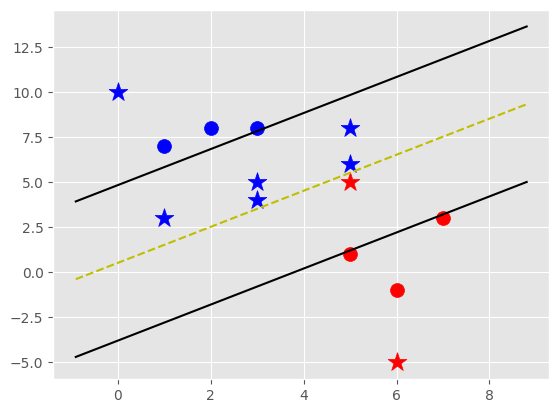

In [32]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
style.use('ggplot')

class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}

        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]

        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None

        # support vectors yi(xi.w+b) = 1


        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # point of expense:
                      self.max_feature_value * 0.001,
                      ]



        # extremely expensive
        b_range_multiple = 2
        # we dont need to take as small of steps
        # with b as we do w
        b_multiple = 5
        latest_optimum = self.max_feature_value*10

        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        #
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b) >= 1:
                                    found_option = False
                                    #print(xi,':',yi*(np.dot(w_t,xi)+b))

                        if found_option:
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]

                if w[0] < 0:
                    optimized = True
                    print('Optimized a step.')
                else:
                    w = w - step

            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2

        for i in self.data:
            for xi in self.data[i]:
                yi=i
                print(xi,':',yi*(np.dot(self.w,xi)+self.b))

    def predict(self,features):
        # sign( x.w+b )
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        if classification !=0 and self.visualization:
            self.ax.scatter(features[0], features[1], s=200, marker='*', c=self.colors[classification])
        return classification

    def visualize(self):
        [[self.ax.scatter(x[0],x[1],s=100,color=self.colors[i]) for x in data_dict[i]] for i in data_dict]

        # hyperplane = x.w+b
        # v = x.w+b
        # psv = 1
        # nsv = -1
        # dec = 0
        def hyperplane(x,w,b,v):
            return (-w[0]*x-b+v) / w[1]

        datarange = (self.min_feature_value*0.9,self.max_feature_value*1.1)
        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]

        # (w.x+b) = 1
        # positive support vector hyperplane
        psv1 = hyperplane(hyp_x_min, self.w, self.b, 1)
        psv2 = hyperplane(hyp_x_max, self.w, self.b, 1)
        self.ax.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')

        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane(hyp_x_min, self.w, self.b, -1)
        nsv2 = hyperplane(hyp_x_max, self.w, self.b, -1)
        self.ax.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # positive support vector hyperplane
        db1 = hyperplane(hyp_x_min, self.w, self.b, 0)
        db2 = hyperplane(hyp_x_max, self.w, self.b, 0)
        self.ax.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')

        plt.show()

data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8],]),

             1:np.array([[5,1],
                         [6,-1],
                         [7,3],])}

svm = Support_Vector_Machine()
svm.fit(data=data_dict)

predict_us = [[0,10],
              [1,3],
              [3,4],
              [3,5],
              [5,5],
              [5,6],
              [6,-5],
              [5,8]]

for p in predict_us:
    svm.predict(p)

svm.visualize()